In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from prettytable import PrettyTable
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('Reviews.csv')
data = df

In [3]:
#Removing Neural reviews
data_s = data[data['Score']!=3]

#Updating Score to 0 or 1
def partition(x):
    if x<3:
        return 0
    return 1

score_upd = data_s['Score']
temp = score_upd.map(partition)
data_s['Score'] = temp

In [4]:
final_data = data_s.drop_duplicates(subset=('UserId','ProfileName','Time','Text'))
final = final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]

In [5]:
#Balancing data Considering only 50k +ve and 50k -ve points
count_p = 0
count_n = 0
b_f =[]
for row in final.itertuples():
    if row[7] == 1 and count_p < 25000:
        b_f.append(row)
        count_p += 1
    if row[7] == 0 and count_n < 25000:
        b_f.append(row)
        count_n += 1
print(count_p)
print(count_n)

25000
25000


In [7]:
fin_bal = pd.DataFrame(b_f)

In [8]:
final = fin_bal.sort_values(['Time'], axis=0)

final_X = final['Text']
final_y = final['Score']

In [9]:
import re
temp_1 =[]
snow = nltk.stem.SnowballStemmer('english')
i = 0
N = len(final_X)
for sentence in final_X:
    sentence = sentence.lower()
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations
    
    words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]        #Splitting the words
    temp_1.append(words)                                                                            # and doing stemming
    print("{0:.2f} %".format((i/N)*100),end ='\r')
    i = i+1
    
final_X = temp_1 

In [10]:
sent = []
for row in final_X:
    seq = ''
    for word in row:
        seq = seq + ' ' + word
    sent.append(seq)

final_X = sent

In [11]:
X_train = final_X[:37000]
X_test = final_X[37000:]
y_train = final_y[:37000]
y_test = final_y[37000:]

In [12]:
# Bag of Words

count_vect = CountVectorizer(max_features = 2000)
bow_X_train = count_vect.fit_transform(X_train)
bow_X_test = count_vect.transform(X_test)

In [13]:
bases = [i for i in range(1,200,50)]
depth = [i for i in range(1,100,20)]
clf = XGBClassifier(booster='gbtree', )
param_grid = {'max_depth':depth,'n_estimators':bases}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(bow_X_train, y_train)
print("best depth = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best depth =  {'max_depth': 21, 'n_estimators': 151}
Accuracy on train data =  85.14324324324323


In [14]:
optimal_depth = a.get('max_depth')
optimal_bases = a.get('n_estimators')
print(optimal_depth)
print(optimal_bases)

21
151


In [15]:
clf = XGBClassifier(booster='gbtree',max_depth=optimal_depth,n_estimators=optimal_bases)

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc = accuracy_score(y_test, pred) * 100
pre = precision_score(y_test, pred) * 100
rec = recall_score(y_test, pred) * 100
f1 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc))
print('\nprecision=%f%%' % (pre))
print('\nrecall=%f%%' % (rec))
print('\nF1-Score=%f%%' % (f1))


Accuracy=86.153846%

precision=83.057029%

recall=86.558397%

F1-Score=84.771574%


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


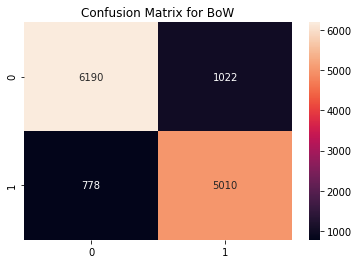

In [16]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for BoW')
plt.show()

** Random Forest **

In [17]:
bases = [i for i in range(1,200,50)]
depth = [i for i in range(1,151,50)]
clf = RandomForestClassifier()
param_grid = {'max_depth':depth,'n_estimators':bases}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(bow_X_train, y_train)
print("best depth = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best depth =  {'max_depth': 101, 'n_estimators': 151}
Accuracy on train data =  84.17567567567568


In [18]:
optimal_depth1 = a.get('max_depth')
optimal_bases1 = a.get('n_estimators')
print(optimal_depth1)
print(optimal_bases1)

101
151


In [19]:
clf = RandomForestClassifier(max_depth=optimal_depth1,n_estimators=optimal_bases1,n_jobs=3)

clf.fit(bow_X_train,y_train)

pred = clf.predict(bow_X_test)

acc1 = accuracy_score(y_test, pred) * 100
pre1 = precision_score(y_test, pred) * 100
rec1 = recall_score(y_test, pred) * 100
f11 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc1))
print('\nprecision=%f%%' % (pre1))
print('\nrecall=%f%%' % (rec1))
print('\nF1-Score=%f%%' % (f11))


Accuracy=85.376923%

precision=82.033954%

recall=85.988252%

F1-Score=83.964572%


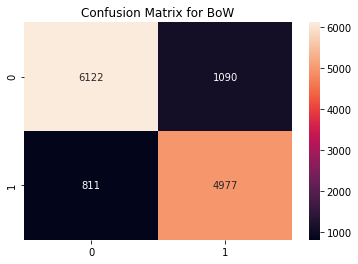

In [20]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix for BoW')
plt.show()

## TF-IDF ##

In [21]:
tf_idf = TfidfVectorizer(max_features=2000)
tf_X_train = tf_idf.fit_transform(X_train)
tf_X_test = tf_idf.transform(X_test)

In [22]:
bases = [i for i in range(1,200,50)]
depth = [i for i in range(1,30,6)]
clf = XGBClassifier(booster='gbtree')
param_grid = {'max_depth':depth,'n_estimators':bases}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(tf_X_train, y_train)
print("best depth = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best depth =  {'max_depth': 19, 'n_estimators': 151}
Accuracy on train data =  85.02702702702703


In [23]:
optimal_depth2 = a.get('max_depth')
optimal_bases2 = a.get('n_estimators')
print(optimal_depth2)
print(optimal_bases2)

19
151


In [24]:
clf = XGBClassifier(booster='gbtree',max_depth=optimal_depth2,n_estimators=optimal_bases2)

clf.fit(tf_X_train,y_train)

pred = clf.predict(tf_X_test)

acc2 = accuracy_score(y_test, pred) * 100
pre2 = precision_score(y_test, pred) * 100
rec2 = recall_score(y_test, pred) * 100
f12= f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc2))
print('\nprecision=%f%%' % (pre2))
print('\nrecall=%f%%' % (rec2))
print('\nF1-Score=%f%%' % (f12))


Accuracy=85.830769%

precision=82.806784%

recall=86.040083%

F1-Score=84.392476%


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


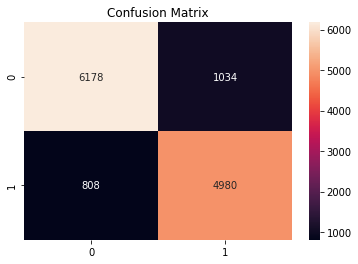

In [25]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [26]:
bases = [i for i in range(1,200,50)]
depth = [i for i in range(1,151,50)]
clf = RandomForestClassifier()
param_grid = {'max_depth':depth,'n_estimators':bases}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3,n_jobs = 3)
grid.fit(tf_X_train, y_train)
print("best depth = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best depth =  {'max_depth': 101, 'n_estimators': 151}
Accuracy on train data =  84.24324324324324


In [27]:
optimal_depth3 = a.get('max_depth')
optimal_bases3 = a.get('n_estimators')
print(optimal_depth3)
print(optimal_bases3)

101
151


In [28]:
clf = RandomForestClassifier(max_depth=optimal_depth3,n_estimators=optimal_bases3,n_jobs=3)

clf.fit(tf_X_train,y_train)

pred = clf.predict(tf_X_test)

acc3 = accuracy_score(y_test, pred) * 100
pre3 = precision_score(y_test, pred) * 100
rec3 = recall_score(y_test, pred) * 100
f13 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc3))
print('\nprecision=%f%%' % (pre3))
print('\nrecall=%f%%' % (rec3))
print('\nF1-Score=%f%%' % (f13))


Accuracy=85.569231%

precision=82.086614%

recall=86.454734%

F1-Score=84.214069%


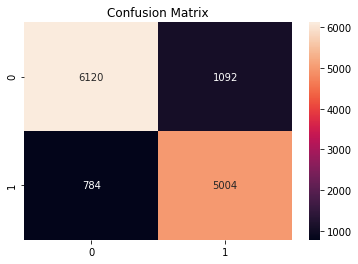

In [29]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [31]:
w2v_data = X_train

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words
    
train_w2v = Word2Vec(splitted,min_count=5,size=150, workers=4)

avg_X_train = []
for row in splitted:
    vec = np.zeros(150)
    count = 0
    for word in row:
        try:
            vec += train_w2v[word]
            count += 1
        except:
            pass
    avg_X_train.append(vec/count)
    
#================================================================
w2v_data = X_test

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words
    
train_w2v = Word2Vec(splitted,min_count=5,size=150, workers=4)

avg_X_test = []
for row in splitted:
    vec = np.zeros(150)
    count = 0
    for word in row:
        try:
            vec += train_w2v[word]
            count += 1
        except:
            pass
    if count==0:
        avg_X_test.append(vec)
    else:
        avg_X_test.append(vec/count)

In [33]:
bases = [i for i in range(50,101,25)]
depth = [i for i in range(1,122,40)]
clf = XGBClassifier(booster='gbtree')
param_grid = {'max_depth':depth,'n_estimators':bases}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3)
grid.fit(np.array(avg_X_train), y_train)
print("best depth = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best depth =  {'max_depth': 41, 'n_estimators': 100}
Accuracy on train data =  83.87567567567568


In [34]:
optimal_depth4 = a.get('max_depth')
optimal_bases4 = a.get('n_estimators')
print(optimal_depth4)
print(optimal_bases4)

41
100


In [35]:
clf = XGBClassifier(booster='gbtree',max_depth=optimal_depth4,n_estimators=optimal_bases4)

clf.fit(np.array(avg_X_train),y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=41, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [36]:
pred = clf.predict(avg_X_test)

acc4 = accuracy_score(y_test, pred) * 100
pre4 = precision_score(y_test, pred) * 100
rec4 = recall_score(y_test, pred) * 100
f14= f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc4))
print('\nprecision=%f%%' % (pre4))
print('\nrecall=%f%%' % (rec4))
print('\nF1-Score=%f%%' % (f14))


Accuracy=76.015385%

precision=78.331919%

recall=63.769869%

F1-Score=70.304762%


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


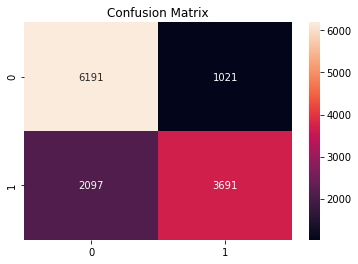

In [37]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

** Random Forest **

In [40]:
bases = [i for i in range(50,101,25)]
depth = [i for i in range(1,122,40)]
clf = RandomForestClassifier()
param_grid = {'max_depth':depth,'n_estimators':bases}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 5,n_jobs = 3)
grid.fit(np.array(avg_X_train), y_train)
print("best depth = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best depth =  {'max_depth': 81, 'n_estimators': 100}
Accuracy on train data =  83.07567567567567


In [41]:
optimal_depth5 = a.get('max_depth')
optimal_bases5 = a.get('n_estimators')
print(optimal_depth5)
print(optimal_bases5)

81
100


In [42]:
clf = RandomForestClassifier(max_depth=optimal_depth5,n_estimators=optimal_bases5,n_jobs=3)

clf.fit(avg_X_train,y_train)

pred = clf.predict(avg_X_test)

acc5 = accuracy_score(y_test, pred) * 100
pre5 = precision_score(y_test, pred) * 100
rec5 = recall_score(y_test, pred) * 100
f15 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc5))
print('\nprecision=%f%%' % (pre5))
print('\nrecall=%f%%' % (rec5))
print('\nF1-Score=%f%%' % (f15))


Accuracy=74.023077%

precision=81.648727%

recall=53.731859%

F1-Score=64.811920%


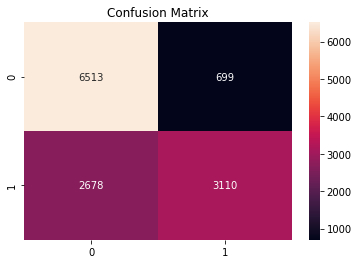

In [43]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

## TF-IDF W2V ##

In [64]:
tf_w_data = X_train
tf_idf = TfidfVectorizer(max_features=2000)
tf_idf_data = tf_idf.fit_transform(tf_w_data)
tf_train_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []
for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in splitted:
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    #print(vec)
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    tf_train_data.append(vec)
    i = i + 1
    
    
    
#====================================================================================

tf_w_data = X_test
tf_idf_data = tf_idf.transform(tf_w_data)
tf_test_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []
for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in splitted:
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    tf_test_data.append(vec)
    i = i + 1

In [66]:
bases = [i for i in range(1,200,50)]
depth = [i for i in range(1,122,40)]
clf = XGBClassifier(booster='gbtree')
param_grid = {'max_depth':depth,'n_estimators':bases}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3)
grid.fit(np.array(tf_train_data), y_train)
print("best depth = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

best depth =  {'max_depth': 81, 'n_estimators': 151}
Accuracy on train data =  76.18108108108108


In [67]:
optimal_depth6 = a.get('max_depth')
optimal_bases6 = a.get('n_estimators')
print(optimal_depth6)
print(optimal_bases6)

81
151


In [68]:
clf = XGBClassifier(booster='gbtree',max_depth=optimal_depth6,n_estimators=optimal_bases6)

clf.fit(np.array(tf_train_data),y_train)

pred = clf.predict(tf_test_data)

acc6 = accuracy_score(y_test, pred) * 100
pre6 = precision_score(y_test, pred) * 100
rec6 = recall_score(y_test, pred) * 100
f16= f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc6))
print('\nprecision=%f%%' % (pre6))
print('\nrecall=%f%%' % (rec6))
print('\nF1-Score=%f%%' % (f16))


Accuracy=78.284615%

precision=73.969281%

recall=79.042847%

F1-Score=76.421949%


C:\Users\HP\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


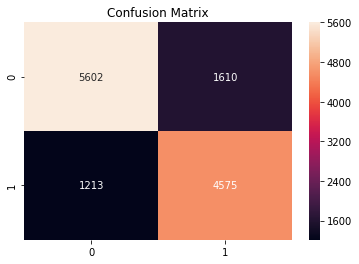

In [69]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

** Random Forest **

In [70]:
bases = [i for i in range(1,200,50)]
depth = [i for i in range(1,151,50)]
clf = RandomForestClassifier()
param_grid = {'max_depth':depth,'n_estimators':bases}
grid = GridSearchCV(estimator = clf,param_grid=param_grid ,cv = 3, n_jobs = 3)
grid.fit(np.array(tf_train_data), y_train)
print("best depth = ", grid.best_params_)
print("Accuracy on train data = ", grid.best_score_*100)
a = grid.best_params_

best depth =  {'max_depth': 101, 'n_estimators': 151}
Accuracy on train data =  76.04864864864865


In [71]:
optimal_depth7 = a.get('max_depth')
optimal_bases7 = a.get('n_estimators')
print(optimal_depth7)
print(optimal_bases7)

101
151


In [72]:
clf = RandomForestClassifier(max_depth=optimal_depth7,n_estimators=optimal_bases7,n_jobs=-1)

clf.fit(np.array(tf_train_data),y_train)

pred = clf.predict(tf_test_data)

acc7 = accuracy_score(y_test, pred) * 100
pre7 = precision_score(y_test, pred) * 100
rec7 = recall_score(y_test, pred) * 100
f17 = f1_score(y_test, pred) * 100

print('\nAccuracy=%f%%' % (acc7))
print('\nprecision=%f%%' % (pre7))
print('\nrecall=%f%%' % (rec7))
print('\nF1-Score=%f%%' % (f17))


Accuracy=77.953846%

precision=73.694453%

recall=78.507256%

F1-Score=76.024762%


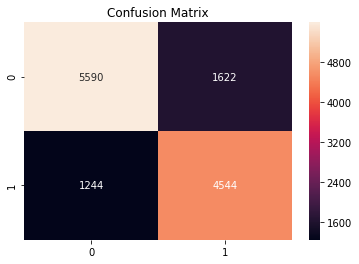

In [73]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [74]:
x = PrettyTable()

vec1 = "BoW"
vec2 = "Tf-IDF"
vec3 = "Avg W2V"
vec4 = "Tf-Idf W2V"

model1 = 'GBDT'
model2 = 'RF'

x.field_names = ["Vectorizer","Model","Opt_Depth","Opt_learners","Test_Error(%)","Precision(%)","Recall(%)","F1-Score(%)"]

err = np.around(100-acc, decimals = 2) 
pre = np.around(pre, decimals = 2)
rec = np.around(rec, decimals = 2)
f1 = np.around(f1, decimals = 2)

err1 = np.around(100-acc1, decimals = 2) 
pre1 = np.around(pre1, decimals = 2)
rec1 = np.around(rec1, decimals = 2)
f11 = np.around(f11, decimals = 2)

err2 = np.around(100-acc2, decimals = 2) 
pre2 = np.around(pre2, decimals = 2)
rec2 = np.around(rec2, decimals = 2)
f12 = np.around(f12, decimals = 2)

err3 = np.around(100-acc3, decimals = 2) 
pre3 = np.around(pre3, decimals = 2)
rec3 = np.around(rec3, decimals = 2)
f13 = np.around(f13, decimals = 2)

err4 = np.around(100-acc4, decimals = 2) 
pre4 = np.around(pre4, decimals = 2)
rec4 = np.around(rec4, decimals = 2)
f14 = np.around(f14, decimals = 2)

err5 = np.around(100-acc5, decimals = 2) 
pre5 = np.around(pre5, decimals = 2)
rec5 = np.around(rec5, decimals = 2)
f15 = np.around(f15, decimals = 2)

err6 = np.around(100-acc6, decimals = 2) 
pre6 = np.around(pre6, decimals = 2)
rec6 = np.around(rec6, decimals = 2)
f16 = np.around(f16, decimals = 2)

err7 = np.around(100-acc7, decimals = 2) 
pre7 = np.around(pre7, decimals = 2)
rec7 = np.around(rec7, decimals = 2)
f17 = np.around(f17, decimals = 2)


x.add_row([vec1,model1,optimal_depth,optimal_bases,err,pre,rec,f1])
x.add_row([vec1,model2,optimal_depth1,optimal_bases1,err1,pre1,rec1,f11])
x.add_row([vec2,model1,optimal_depth2,optimal_bases2,err2,pre2,rec2,f12])
x.add_row([vec2,model2,optimal_depth3,optimal_bases3,err3,pre3,rec3,f13])
x.add_row([vec3,model1,optimal_depth4,optimal_bases4,err4,pre4,rec4,f14])
x.add_row([vec3,model2,optimal_depth5,optimal_bases5,err5,pre5,rec5,f15])
x.add_row([vec4,model1,optimal_depth6,optimal_bases6,err6,pre6,rec6,f16])
x.add_row([vec4,model2,optimal_depth7,optimal_bases7,err7,pre7,rec7,f17])


print(x)

+------------+-------+-----------+--------------+---------------+--------------+-----------+-------------+
| Vectorizer | Model | Opt_Depth | Opt_learners | Test_Error(%) | Precision(%) | Recall(%) | F1-Score(%) |
+------------+-------+-----------+--------------+---------------+--------------+-----------+-------------+
|    BoW     |  GBDT |     21    |     151      |     13.85     |    83.06     |   86.56   |    84.77    |
|    BoW     |   RF  |    101    |     151      |     14.62     |    82.03     |   85.99   |    83.96    |
|   Tf-IDF   |  GBDT |     19    |     151      |     14.17     |    82.81     |   86.04   |    84.39    |
|   Tf-IDF   |   RF  |    101    |     151      |     14.43     |    82.09     |   86.45   |    84.21    |
|  Avg W2V   |  GBDT |     41    |     100      |     23.98     |    78.33     |   63.77   |     70.3    |
|  Avg W2V   |   RF  |     81    |     100      |     25.98     |    81.65     |   53.73   |    64.81    |
| Tf-Idf W2V |  GBDT |     81    |   

** Summary and Observations **

* Accuracy is high on GBDT with  BoW vectorizer *
* Seen very less accuraccies on W2V models
* everything is shown in pretty table format
* plotted heat maps for better understanding of results